# Pandemic Normalcy Index as Financial Factor

In [2]:
!pip install yfinance
!pip install yahoofinancials

  Created wheel for multitasking: filename=multitasking-0.0.10-py3-none-any.whl size=8493 sha256=fbd6e62b15ba7100117108d154951118f847e156ad7c91e53c163e4d42667591
  Stored in directory: c:\users\worldquant\appdata\local\pip\cache\wheels\21\c9\66\b41c847de65c7985db52ec21d59996841598b8b0e93f2b9500
Successfully built multitasking
  Attempting uninstall: requests
    Found existing installation: requests 2.24.0
    Uninstalling requests-2.24.0:
      Successfully uninstalled requests-2.24.0
  Created wheel for yahoofinancials: filename=yahoofinancials-1.6-py3-none-any.whl size=15194 sha256=da70fb14b8ffdf1f95d25283d4ff82f11f340ab5163f9c192c43e57b8b18d5c4
  Stored in directory: c:\users\worldquant\appdata\local\pip\cache\wheels\6a\90\0c\08c7ac2ce60b9ac91529417d471e59244f9f96848c86f14809
Successfully built yahoofinancials


In [174]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from datetime import datetime
sns.set(rc={'figure.figsize':(20,10)})

# yahoo finance:
import yfinance as yf
from yahoofinancials import YahooFinancials

#### Import data

The normalcy features were generated by The Economist and are available under the Creative Commons Attribution 4.0 International License. The data covers 50 countries across eight variables, and a population-weighted "world" aggregate of those 50 countries.

The market's performance data is from Yahoo Finance. I choosed the S&P500 total returns as a benchmark for the whole market performance. 

In [21]:
# import data
normalcy = pd.read_csv("normalcy-index.csv")
normalcy["date"] = pd.to_datetime(normalcy["date"])
normalcy = normalcy.set_index('date')

print(f"normalcy df size={normalcy.shape}")
print(f"columns list={list(normalcy.columns)}")
normalcy.head()

normalcy df size=(34983, 10)
columns list=['iso3c', 'cinema', 'flights', 'office_occupancy', 'public_transport', 'retail_footfall', 'time_outside', 'sports_attendance', 'traffic', 'overall']


,iso3c,cinema,flights,office_occupancy,public_transport,retail_footfall,time_outside,sports_attendance,traffic,overall
date,,,,,,,,,,
2020-02-28,ARE,48.886518,96.943468,102.044649,98.573704,98.714286,99.000000,NaN,67.810152,89.046583
2020-02-29,ARE,51.289476,96.677830,102.187506,98.529055,98.857143,99.071429,NaN,67.872437,89.378410
2020-03-01,ARE,54.000001,96.507063,102.399564,98.435302,99.000000,99.071429,NaN,68.262108,89.799361
2020-03-02,ARE,57.018093,96.279374,102.611622,98.270120,99.071429,99.071429,NaN,67.679351,90.107785
2020-03-03,ARE,60.343752,95.994762,102.776803,97.962082,99.214286,99.071429,NaN,67.623297,90.500108


## Data description
| Column name        | Description                                                                     | Weight | Source                                                                          |
| ------------------ | ------------------------------------------------------------------------------- | ------ | ------------------------------------------------------------------------------- |
| iso3c              | Country's iso3c code                                                            | NA     | NA                                                                              |
| date               | Date of data, yyyy-mm-dd                                                        | NA     | NA                                                                              |
| flights            | Flights departing domestic airports                                             | 0.1111 | UN ICAO                                                                         |
| public\_transport  | transport hubs of three largest cities, population-weighted average | 0.1111 | Google; Wind Data (for China)                                                   |
| traffic            | Congestion levels in three largest cities, population-weighted average          | 0.1111 | TomTom; Wind Data (for China)                                                   |
| cinema             | Box office revenues, local currency (weekly data)                               | 0.1111 | Box Office Mojo                                                                 |
| sports\_attendance | Attendance at professional sports events                                        | 0.1111 | Transfermarkt; afltables.com; hockey-reference.com; pro-football-reference.com; |
| time\_outside      | Time spent outside the home, country aggregate                                  | 0.1111 | Google; Economist estimate for China                                            |
| office\_occupancy  | Footfall in workplaces of three largest cities, population-weighted average     | 0.1666 | Google; Economist estimate for China                                            |
| retail\_footfall   | Footfall in "retail and recreation" sites, country aggregate                    | 0.1666 | Google; Economist estimate for China                                            |
| overall            | Weighted-average of 8 indicators above                                          | 1      | NA                                                                              |

In [20]:
# import S&P data:
spy = yf.download('SPY', 
                      start='2020-01-01', 
                      progress=False,
)[["Adj Close"]]
spy.columns = ["price"]
spy.head()

,price
Date,
2019-12-31,311.803223
2020-01-02,314.719147
2020-01-03,312.336121
2020-01-06,313.527618
2020-01-07,312.646057


#### simple data process

In [22]:
normalcy.head()

,iso3c,cinema,flights,office_occupancy,public_transport,retail_footfall,time_outside,sports_attendance,traffic,overall
date,,,,,,,,,,
2020-02-28,ARE,48.886518,96.943468,102.044649,98.573704,98.714286,99.000000,NaN,67.810152,89.046583
2020-02-29,ARE,51.289476,96.677830,102.187506,98.529055,98.857143,99.071429,NaN,67.872437,89.378410
2020-03-01,ARE,54.000001,96.507063,102.399564,98.435302,99.000000,99.071429,NaN,68.262108,89.799361
2020-03-02,ARE,57.018093,96.279374,102.611622,98.270120,99.071429,99.071429,NaN,67.679351,90.107785
2020-03-03,ARE,60.343752,95.994762,102.776803,97.962082,99.214286,99.071429,NaN,67.623297,90.500108


#### Visualize Features

In [197]:
def plot_features(df, features, country=None, title = ""):
    fig = plt.figure(figsize=(20,10))
    fig.subplots_adjust(hspace=0.8, wspace=0.4)
    colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']
    for i in np.arange(1, len(features)+1):
        ax = fig.add_subplot(3, len(features)//3, i)
        tmp = df
        if country:
            tmp = df[df["iso3c"]==country]        
        sns.lineplot(data=tmp, x =tmp.index , y = features[i-1],ax=ax, color =colors[i-1],ci=None) 
        plt.xticks(rotation=45)
        ax.set_title(features[i-1], fontsize=15,weight = 'bold')
        plt.xlabel('date', fontsize = 15, weight = 'bold')
        plt.ylabel('index level', fontsize = 15, weight = 'bold')

    fig.savefig(f"./images/{title}.png")
    plt.show()
    


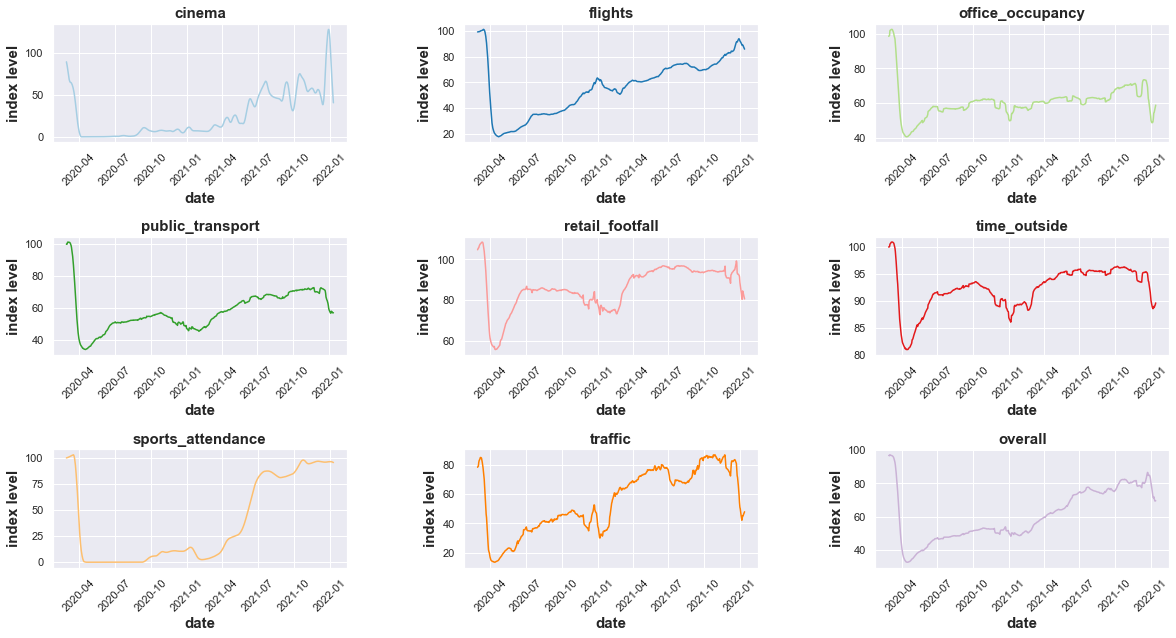

In [198]:
plot_features(normalcy,normalcy.select_dtypes(include=np.number).columns, "USA", "normalcy_features_usa")

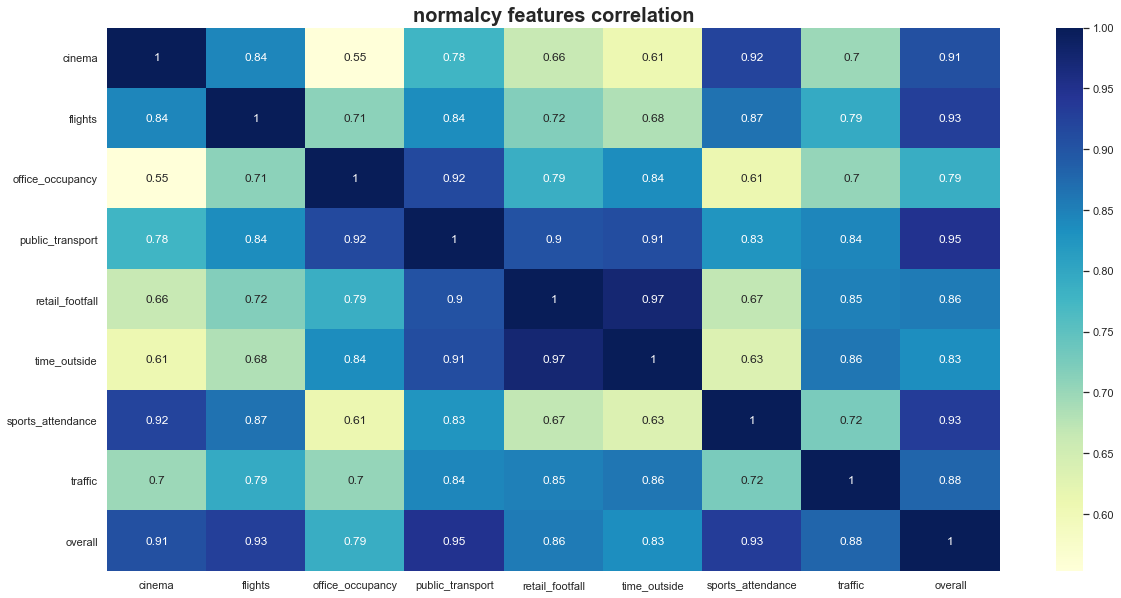

In [189]:
title = "normalcy features correlation"
fig, ax = plt.subplots(figsize=(20,10))

ax.set_title(title, fontsize=20,weight = 'bold')
sns.heatmap(data=normalcy[normalcy["iso3c"]=="USA"].corr(),annot=True,cmap="YlGnBu")

fig.savefig(f"./images/{title}.png")

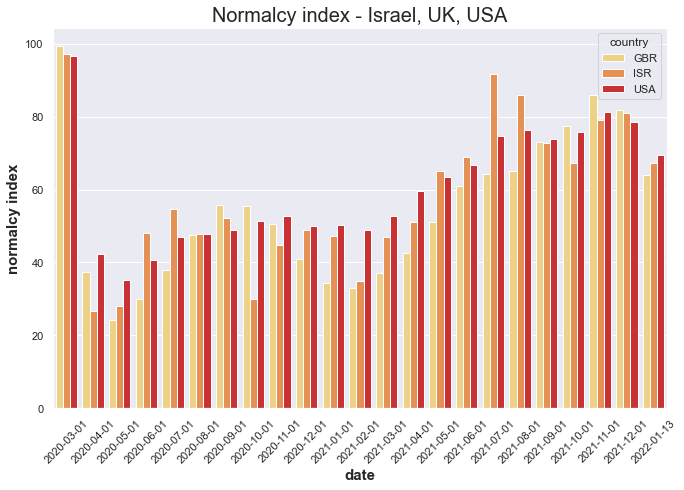

In [182]:
sns.set(rc={'figure.figsize':(11,7)})

countries = ["GBR", "USA", "ISR"]
dates = [datetime(year=2022, month=1, day=13)] + [datetime(year=2020+i, month=j, day=1) for i in range(2) for j in range(1,13)
        ]
tmp = normalcy[
    (normalcy["iso3c"].isin(countries)) &
    (normalcy.index.isin(dates))
][["overall",'iso3c' ]]
tmp.columns = ["normalcy_index", "country"]
tmp.index = tmp.index.map(lambda x:x.date())

fig, ax = plt.subplots()
sns.barplot(x=tmp.index, y="normalcy_index", hue="country", data=tmp, palette=("YlOrRd"))
plt.xticks(rotation = 45)
title = "Normalcy index - Israel, UK, USA"
ax.set_title(title, fontsize=20)
plt.xlabel('date', fontsize = 15, weight = 'bold')
plt.ylabel('normalcy index', fontsize = 15, weight = 'bold')

fig.savefig(f"./images/{title}.png")

## Normalcy Index vs the S&P500

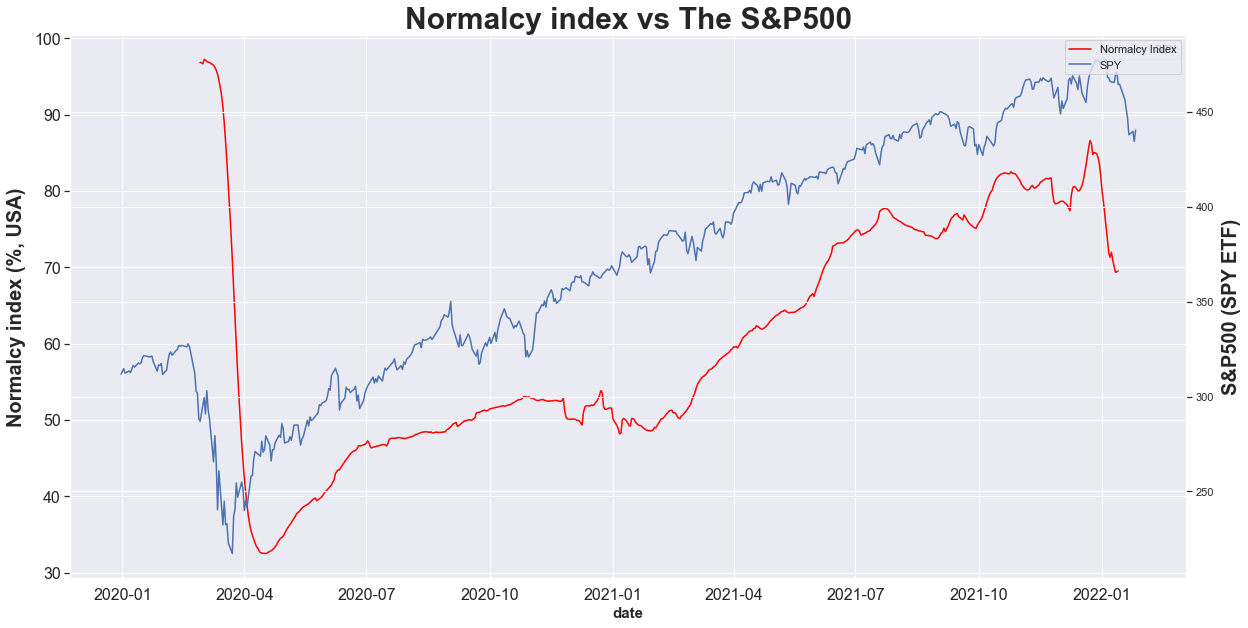

In [208]:
country = "USA"
title = "Normalcy index vs The S&P500"


fig, ax = plt.subplots(figsize=(20,10))
col = "overall"
tmp = normalcy[normalcy["iso3c"]==country]
sns.lineplot(data=tmp, x=tmp.index, y=col, label="Normalcy Index",ci=None, ax=ax, color="red")
ax.set_ylabel("Normalcy index (%, USA)", fontsize=20, labelpad=8,weight = 'bold')
plt.xlabel('date', fontsize = 15, weight = 'bold')

col = "price"
ax2 =ax.twinx()
sns.lineplot(data=spy, x=spy.index, y=spy[col], label="SPY",ci=None, ax=ax2)
ax.set_title(title, fontsize=30, weight="bold")
ax2.set_ylabel("S&P500 (SPY ETF)", fontsize=20, labelpad=8,weight = 'bold')
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)

ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 16)
fig.savefig(f"./images/{title}.png")